# Viewing JWST Spectra with Spectral DB API and SpecViz

## Learning Goals

By the end of this tutorial, you will:
- Understand the difference between searching and downloading JWST spectra with `astroquery.MAST` and `SpectralDB`
- Search for JWST spectra given a set of pixel-level criteria with `SpectralDB`
- Access a JWST spectrum with a known URI using `SpectralDB` API
- View a JWST spectrum JSON object with `SpecViz`

## Introduction

The Barbara A. Mikulski Archive for Space Telescopes (MAST) is the home for all data from the James Webb Space Telescope (JWST), among other telescope data archives. There are multiple ways to search for and download images and spectra from MAST. In this tutorial, we will access a spectrum with a known Uniform Resource Indicator (URI) using the Spectral DB Application Programming Interface (API). Using a correctly formatted URL (Uniform Resource Locator; a web address that starts with https://) request to the API, we can directly access the same content as contained with a .fits file in our Jupyter notebook without having to download and store the .fits file locally. This tutorial will also briefly demonstrate how to plot the spectrum in the `SpecViz` portion of `Jdaviz`. 

At the time of this tutorial, not all publicly available taken by JWST is available through Spectral DB; it currently only contains the final calibrated data science products ("Level 3" products), not lower level calibration products. Additionally, searching for 2D and 3D spectroscopic pixel data is not yet supported. The filename of a 1D spectroscopic products, which are supported in searching, will all end in `_x1d.fits1`. This tutorial retrieves publicly available data, which we can do anonymously; to retrieve proprietary or protected data, you will need to use an authentication token. 

More documentation for [Specviz](https://jdaviz.readthedocs.io/en/latest/specviz/) is available online.

JRK, questions, 
- how should this be written consistently... Spectral DB, Spectraldb, etc. `with` or without formatting?
- how do know if the spectrum you are trying to access is final calibrated science data product? e.g. if searching via MAST portal instead, so skipping straight to the 2nd step.
- See how long the "at the time of this tutorial..." will last.
- Also link to Spectral DB or general API documentation.

## Imports

- numpy to handle array functions
- astropy.io fits for accessing FITS files
- astropy.io ascii for writing an astropy table to a .csv file (for an Exercise)
- astropy.table Table for creating tidy tables of the data
- matplotlib.pyplot for plotting data
- requests to access the API
- astroquery.mast Observations for querying MAST for observations
- json

JRK jdaviz and astroquery may require installation?

JRK go back and see what ends up being used.

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.mast import Observations
import requests
import json
from jdaviz import Specviz
from specutils import Spectrum1D

## Searching for JWST spectra with given pixel parameters

There are many ways to search the MAST database, such as with [`astroquery`](https://astroquery.readthedocs.io/en/latest/mast/mast.html) in Python or with the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) in your web browser. These types of searches are usually designed to be done by object name, region, or proposal or observation ID; in other words, the searches are usually done based on the observing target or the observing plan (such as proposer, instrument, filters, etc.) The Spectral DB API, on the other hand, can search by pixel-level information within the spectrum itself, such as signal-to-noise ratios (SNR), or flux values in certain wavelength ranges; we can search by the actual result of the observing. More documentation is available about how to [Search Spectroscopic Pixel Data](https://mast.stsci.edu/spectra/docs/search_pixels.html) 

The URLs for searching with the Spectral DB API will all begin with https://mast.stsci.edu/spectra/api/v0.1/search? and then be followed by the appropriate keywords.

In the example below, we search for 1D spectra (`product=x1d`) that have a flux of at least 0.2 Jy and SNR of at least 5 in the wavelength range of 14 to 14.5 microns.

JRK - this is completely arbitrary - come up with a compelling science case, e.g. looking for a specific kind of emission or something.


In [2]:
prefix='https://mast.stsci.edu/spectra/api/v0.1/search?'
keywords='product=x1d&wavelength=14,14.5&derSnr.gt=5&flux.gte=0.2'
url=prefix+keywords
print(url)

https://mast.stsci.edu/spectra/api/v0.1/search?product=x1d&wavelength=14,14.5&derSnr.gt=5&flux.gte=0.2


In [3]:
r1=requests.get(url)
r1.status_code

200

In [4]:
r1.json().keys()

dict_keys(['status', 'query', 'results'])

Above, we can see the contents of the `r` JSON object. The three keys tell us about the status of our request, the query itself, and also, the results. Let's examine what is contained in the results dictionary:

In [5]:
lenr=len(r1.json()['results'])
print('Length of results: '+str(lenr))
print('First result: ')
print(r1.json()['results'][0])
print('Second result: ')
print(r1.json()['results'][100])

Length of results: 2160
First result: 
{'fileName': 'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits', 'x': 817, 'y': None, 'wavelength': 14.002500212052837, 'flux': 0.577426376942338, 'derSnr': 269.32294857030854}
Second result: 
{'fileName': 'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits', 'x': 883, 'y': None, 'wavelength': 14.200500213773921, 'flux': 0.5959414144803693, 'derSnr': 269.32294857030854}


It seems every individual pixel (including each individual portion of a spectrum) that met our criteria gets included in our results. So, the same spectrum is represented multiple times. Let's view how many unique individual filenames are in our results list. Below, we will make an array with all of the filenames and then print the unique names.

In [6]:
allfilenames=[]
for i in range(0,lenr): allfilenames.append(r1.json()['results'][i]['fileName'])
# JRK this is very inefficient.

In [7]:
uniquefilenames=np.unique(allfilenames)
uniquefilenames

array(['jw01039-c1000_t001_miri_ch3-shortmediumlong-_x1d.fits',
       'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits',
       'jw01047-o001_t006_miri_ch3-medium_x1d.fits',
       'jw01050-o005_t005_miri_ch3-medium_x1d.fits',
       'jw01328-c1006_t014_miri_ch3-longshortmedium-_x1d.fits',
       'jw01328-c1007_t023_miri_ch3-shortlongmedium-_x1d.fits',
       'jw01328-o015_t014_miri_ch3-mediumshortlong-_x1d.fits',
       'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits',
       'jw01349-c1004_t002_miri_ch3-longmediumshort-_x1d.fits',
       'jw01349-c1007_t004_miri_ch3-shortlongmedium-_x1d.fits',
       'jw01349-o001_t002_miri_ch3-longshortmedium-_x1d.fits',
       'jw01349-o002_t004_miri_ch3-mediumshortlong-_x1d.fits',
       'jw01349-o010_t003_miri_ch3-longmediumshort-_x1d.fits'],
      dtype='<U53')

The results give us science information about the pixels (wavelength, flux, and SNR) and just the filename that is associated with the pixel. We are missing a lot of metadata, such as what the targets of these spectra even are! The filenames themselves do give us some information about the observations. Using 'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits' as an example:
- 01039 is the program number.
- 005 is the observation number.
- 001 is the visit number. 
- MIRI is the instrument used.
- 3 is the instrument channel used.
- JRK I'm not sure the right terminolgoy for shortlongmedium, mediumshortlong, etc. An instrument mode?
- x1d indicates this is a 1D spectrum. JRK find link to a list of all the possibilities there.

To find more information about any of these spectra, we can use `Observations.query_criteria` imported above from `astroquery.mast`. We can query any of the metadata that are available. JWST spectra will be unique identified by the majority of their filenames; everything up to the final `_x1d.fits` (or similar suffix) will be in the `obs_id` kewyord of the metadata. In practice, you might search for metadata for all of the filenames listed in our `uniquefilenames` variable above. For the purpose of this tutorial, because the results above from Spectral DB will change with time as more JWST data becomes available, we will use filename 'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits'. 

First, we will split the string everywhere there is a '_' and then rejoin it together with everything but the last suffix. We'll then search the MAST archive with astroquery and print just some of the information form the resulting table.

In [8]:
filename='jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits'
search=str.join('_',filename.split('_')[0:-1])
print(search)
obs_table=Observations.query_criteria(obs_id=search)
print(obs_table['target_name','s_ra','s_dec'])
#obs_table=Observations.query_criteria(dataURL=uniquefilenames[0]) What should that be

jw01039-o005_t001_miri_ch3-shortlongmedium-
target_name        s_ra             s_dec      
----------- ----------------- -----------------
   NGC 6552 270.0302116666667 66.61509722222222


We now know that this spectrum, which met our criteria for flux and signal to noise in a certain wavelength range, was taken of the barred spiral galaxy NGC 6225. Let's continue to retrieve the spectrum itself.

## Using Spectral DB API to retrieve a JWST spectrum with known URI

Each high-level data product in the JWST data archive has a unique URI (Uniform Resource Locator) that consists of a prefix (mast:JWST/product) and the file name.

JRK need to explain or demonstrate other ways to find the URI, for example if you were searching in the MAST portal. You'd have to limit yourself to level-3 science products. 

The URLs for retrieving data with the Spectral DB API will all begin with https://mast.stsci.edu/spectra/api/v0.1/retrieve?. In our case, with a known URI, we'll append 'uri=' and then the spectrum's URI. In the code block below, we combine those two strings and print the final result. 

JRK: I thought you could use column 'dataURL' from the astroquery table, but it ends in s3d.fits not x1d.fits. 

In [9]:
prefix='https://mast.stsci.edu/spectra/api/v0.1/retrieve?uri='
uri='mast:JWST/product/'+filename
#uri=obs_table['dataURL'][0] # JRK, PROBLEM, this ends in s3d.fits not x1d.fits
url=prefix+uri
print(url)

https://mast.stsci.edu/spectra/api/v0.1/retrieve?uri=mast:JWST/product/jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits


By using requests.get with our URL, we ask the Spectral DB API to send the spectrum information associated with that unique URI. The resulting object, `r`, is a JSON (JavaScript Object Notation) object, used to store and exchanged data in a standardized format. Next, we print the status code of the `r` object; a code of 200 means success.

In [10]:
r2=requests.get(url)
r2.status_code

200

Similarly to our result from searching, this result `r` contains multiple keys:

In [11]:
r2.json().keys()

dict_keys(['status', 'message', 'uri', 'filename', 'column_metadata', 'data'])

The `r2` object itself looks a lot like a dictionary of dictionaries. It contains information about our request (status, message, uri, filename), a dictionary of the metadata for each column, and a dictionary of the array data we'd expect for a spectrum (e.g. wavelength, flux, and some characterization of the error). 

Below, we exact the 'data' dictionary and plot the wavelength vs. flux columns using the built-in matplotlib routines. 

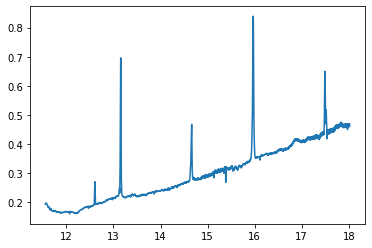

In [12]:
data=r2.json()['data']
plt.plot(data['wavelength'],data['flux'])

### Exercise 1

Find the units of the wavelength and frequency columns from the column metadata in the JSON object and add axis labels to the plot. 

um
Jy


Text(0, 0.5, 'Flux (Jy)')

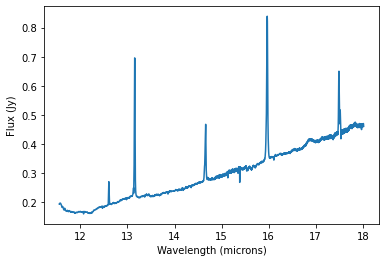

In [13]:
# Place for code for Exercise 1
# My solution (to be moved after finishing notebook)
print(r2.json()['column_metadata']['wavelength']['units'])
print(r2.json()['column_metadata']['flux']['units'])
plt.plot(data['wavelength'],data['flux'])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (Jy)')

## Viewing the Spectrum in Specviz

Though the built-in plotting routines in Python are helpful to making sure we understand the structure of the data we retrieve from the MAST archive, they are not particularly useful for detailed spectral analysis. The [Jdaviz](https://jdaviz.readthedocs.io/en/latest/) package is specially built for data visualization and analysis of images (using Imviz), 1-dimensional spectra (Specviz), spectral cubes (Cubeviz), and multi-object spectroscopy (Mosviz).  

First, we load and show a new instance of Specviz, since we are using a one-dimensional spectrum.

In [14]:
specviz = Specviz()
specviz.show()

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

Next, we need to convert the information in our `data` dictionary into an object that can be understood by Specviz. We will create a Spectrum1D object from the specutils package. At minimum, we need to provide the array that defines the horizontal axis (the spectral_axis keyword) and the array that defines the vertical axis (the flux keyword). Both arrays need to have the correct units, so we can multiply their respective columns in `data` by an astropy units object. "um" is the standard abbreviation for microns. (To know why these units were used, be sure to try Exercise 1 above!)

JRK should other metadata, etc. be provided in spec1d, that I assume would be already loaded in if we used the .fits file? Will difference science use cases encounter problems if other metadata is not provided?

In [15]:
wavelength=data['wavelength']*u.um
flux=data['flux']*u.Jy
error=data['fluxErr']*u.Jy
spec1d=Spectrum1D(spectral_axis=wavelength,flux=flux)#,uncertainty=error) This results in error
# INFO:astropy:uncertainty should have attribute uncertainty_type.

In the next code block, we load the spectrum object into Specviz and provide a helpful label ("From JSON"). By default, the spectrum will appear in our specviz window above, from earlier in the notebook.

If we added ```specviz.show()``` to the code block below, another (identical) specviz window would be shown here. Calling ```specviz.show()``` frequently would create a lot of windows and make your Jupyter notebook quite long and with redundant visual information.

In [16]:
specviz.load_spectrum(spec1d,data_label="From JSON")

JRK, comment on the units? 

JRK, wrapping it up here, provide some links to other tutorials or documentation that shows how to do various things with Specviz. Ideas: the finding redshift tutorial, other things to do with spectral lines, modeling, continuum baseline, etc. etc....

### Exercise 2

Download the file associated with this URI using astroquery (link to download instructions). Load the spectrum into Specviz, labeling it "From file", and confirm that the contents of the two spectra (from JSON and from file) are identical.

In [17]:
# Place for code for Exercise 2
result=Observations.download_file(uri)
filename=uri.split('/')[-1]
print(filename)
specviz.load_spectrum(filename,data_label="From File")

INFO:astroquery:Found cached file /Users/julia/Documents/GitHub/notebooks-stsci/notebooks/MAST/spectraldb_and_specviz/jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits with expected size 388800.


INFO: Found cached file /Users/julia/Documents/GitHub/notebooks-stsci/notebooks/MAST/spectraldb_and_specviz/jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits with expected size 388800. [astroquery.query]
jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits


## About this Notebook

**Author**: Julia Kamenetzky, ScienceBetter Consultant (JRK what email address to put?)

**Updated On:*** TBD

## Citations

JRK do this, add logo and top of page and lines at bottom